In [54]:
import pandas as pd
import pathlib

df = pd.read_csv("trial_HRM.csv")
#HRV_df = pd.read_csv("trial_HRV.csv")

#df = pd.read_csv("second_hrm_trial.csv")

In [55]:
import matplotlib.pyplot as plt
import numpy as np

#get magnitude of PPG measurement
amp = df['green']
amp_array = amp.to_numpy()

samples = df['sample_count']
rr = df['rr']
timestamp = df['sample_time']

#normalize
max = np.max(amp_array)
min = np.min(amp_array)

amp_array_norm = (amp_array - min) / (max - min)

In [56]:
#get synthetic acceleration 
acx = df['acceleration_x']
acy = df['acceleration_y']
acz = df['acceleration_z']

syn_ac = np.square(acx) + np.square(acy) + np.square(acz)
syn_ac = np.power(syn_ac, 1/2)

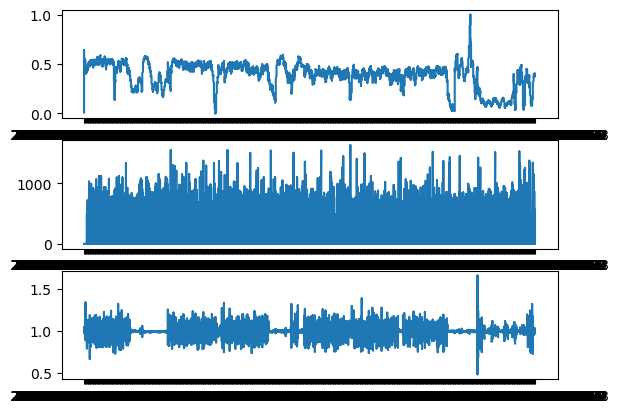

In [57]:
#get the RR plot
figure, axis = plt.subplots(3)
axis[0].plot(timestamp, amp_array_norm)
axis[1].plot(timestamp, rr)
axis[2].plot(timestamp, syn_ac)

#rr plot seems to follow the direction of PPG measurement as opposed to acceleration which appears to be random here making everything a bit complicated 

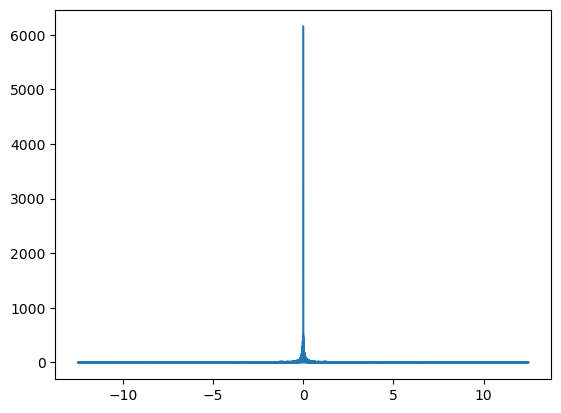

In [58]:
#FFT for noise
from scipy.fft import rfft, rfftfreq
from scipy.fft import fft, fftfreq

#do FFT on PPG data to get spectrum
n = amp_array_norm.size
fs = 25

fft = fft(amp_array_norm)
fftfreq = fftfreq(n, 1/fs)

rfft = rfft(amp_array_norm)
rfftfreq = rfftfreq(n, 1/fs)

plt.plot(fftfreq, np.abs(fft))
#plt.plot(rfftfreq, np.abs(rfft))

RMSSD 

method that calculates differences between successive IBIs 
then squares them 
then averages all of the results 
and then takes square root 

WHICH IS EASY TO DEVELOP ON YOUR OWN

In [59]:
import numpy as np

#RMSSD 
#removing all zero values to get only actual IBIs
rr_nz = rr[rr!=0]

#RMSSD: root mean square of successive differences
#turn this into a function at some point 
rr_nz_array = rr_nz.to_numpy() #float64 

itersize = rr_nz_array.size
squares = 0

for i in range(itersize-2) : 
    squares += np.square(rr_nz_array[i+1] - rr_nz_array[i])

average = squares / (itersize-1)

RMSSD = np.power(average, 1/2)

print(RMSSD)

#you get RMSSD here but you need to use that later to compare between different samples
#turn it into a function to use whenever 


331.0480047219925


SPECTRAL ANALYSIS

Doing an FFT. Now, supposedly, I should be seeing something here like an HF and LF component but I'm not. Which means something is wrong!

In [90]:
from scipy.fft import rfft, rfftfreq
from scipy.fft import fft, fftfreq

#do FFT on PPG data to get spectrum
rr_array = rr.to_numpy()

rr_array_no_dc = rr_array - np.mean(rr_array) #take out DC συνιστωσα

rr_array_clean = rr_array[(rr_array > 300) & (rr_array < 2000)] 
rr_array_clean = rr_array_clean - np.mean(rr_array_clean)



FFT without interpolation here

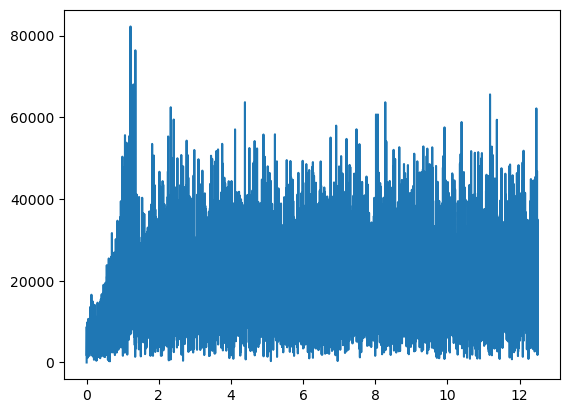

In [91]:
#this is FFT without interpolation that works to actually denoise the signal
n = rr_array_no_dc.size
fs = 25

fft = fft(rr_array_no_dc)
fftfreq = fftfreq(n, 1/fs)

rfft = rfft(rr_array_no_dc)
rfftfreq = rfftfreq(n, 1/fs) #right side FFT for only not imaginary numbers (can't recall how those are called but basically magnitude)

#plt.plot(fftfreq, np.abs(fft))
plt.plot(rfftfreq, np.abs(rfft)) 

#data here is not interpolated - due to irrgularity FFT will not show results

FFT with interpolation here

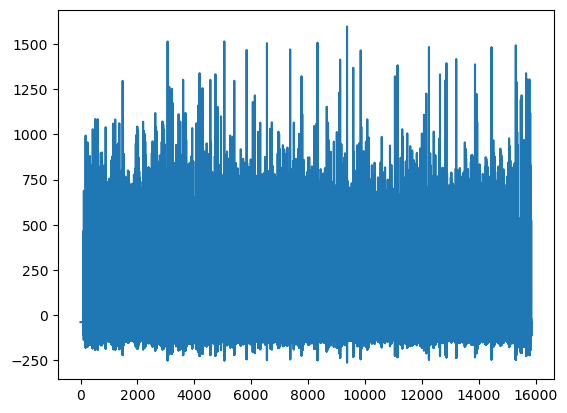

In [92]:
#you need to do Lagrange interpolation on your RR data and autoregressive model for analysis
from scipy.interpolate import CubicSpline

time_size = rr_array_no_dc.size
times = np.empty(time_size, dtype = int)

#do cubic spline interpolation which is better suited for HRV
for i in range(time_size): 
    times[i] = i
cs = CubicSpline(times, rr_array_no_dc)

uniform_times = np.arange(0, time_size, 1/fs) #make a uniform time array so as to also uniform the signal and then do FFT

interpolated_rr = cs(uniform_times)

plt.plot(uniform_times, interpolated_rr) #interpolated has negative times which MAKES NO SENSE GENERALLY SPEAKING

#this makes IBI values turn negative which makes no sense 

(0.0, 0.5)

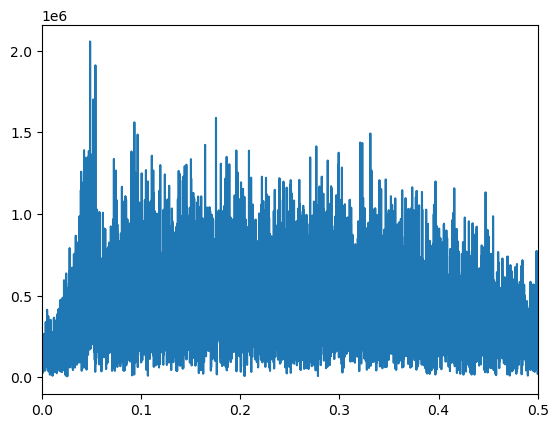

In [93]:
#do FFT of RR signal received from device, interpolated but not otherwise denoised and probably a bit wrong and not smoothed at all
from scipy.fft import rfft, rfftfreq
n = interpolated_rr.size
fs = 25

rfft = rfft(interpolated_rr)
rfftfreq = rfftfreq(n, 1/fs)

plt.plot(rfftfreq, np.abs(rfft)) 
plt.xlim(0, 0.5)

FFT with interpolation and clean data


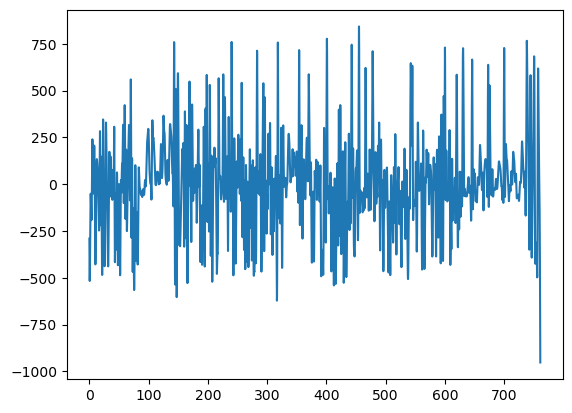

In [94]:
from scipy.interpolate import CubicSpline

time_size = rr_array_clean.size
times = np.empty(time_size, dtype = int)

#do cubic spline interpolation which is better suited for HRV
for i in range(time_size): 
    times[i] = i
cs = CubicSpline(times, rr_array_clean)

uniform_times = np.arange(0, time_size, 1/fs) #make a uniform time array so as to also uniform the signal and then do FFT

interpolated_rr = cs(uniform_times)

plt.plot(uniform_times, interpolated_rr) #interpolated has negative times which MAKES NO SENSE GENERALLY SPEAKING

(0.0, 0.5)

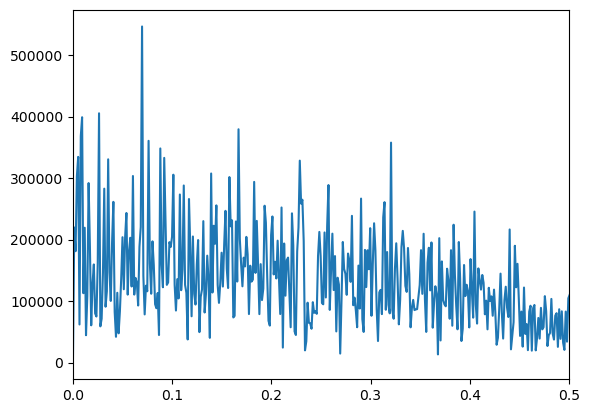

In [95]:
from scipy.fft import rfft, rfftfreq
n = interpolated_rr.size
fs = 25

rfft = rfft(interpolated_rr)
rfftfreq = rfftfreq(n, 1/fs)

plt.plot(rfftfreq, np.abs(rfft)) 
plt.xlim(0, 0.5)

Ok so far we're facing the following problems: 

-without clean data we're taking no noise out
-there's literally no smoothing 
-interpolation is always giving us negative values 
-not sure at all that removing values below 300 and above 2000 ms makes any sense 

DO AUTOREGRESSINO